# The Numerical Sandbox: Compression Experiment

**Romain Beucher**
Version 0.1

romain.beucher@unimelb.edu.au

The following notebook is an implementation of the Numerical Sandbox Compression Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

<tr>
<td> <img src="images/CompressionA.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/CompressionB.png" alt="Drawing" style="width: 500px;"/> </td>
</tr>

Results after 10cm shortenning (Buiter et al., 2006)

In [1]:
import os
import numpy as np
import warnings; warnings.simplefilter('ignore')

import underworld as uw
import underworld.function as fn
import glucifer

import unsupported.scaling as sca
from unsupported.lithopress import lithoPressure
from unsupported.geodynamics import *

In [2]:
uw_output_path = 'sandbox'

if uw.rank() == 0:
    if not os.path.exists(uw_output_path):
        os.makedirs(uw_output_path)

## Scaling

In [3]:
u = sca.UnitRegistry
nd = sca.nonDimensionalize

velocity = 2.5 * u.centimeter / u.hour
model_length = 30. * u.centimeter
model_height = 8. * u.centimeter
refViscosity = 1e7 * u.pascal * u.second
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

sca.scaling["[length]"] = KL.to_base_units()
sca.scaling["[time]"] = Kt.to_base_units()
sca.scaling["[mass]"]= KM.to_base_units()

# General parameters

In [4]:
gravity = nd(9.81 * u.meter / u.second**2)

In [5]:
nx = 400
ny = 100

minX = nd(   0. * u.centimeter)
maxX = nd(  40. * u.centimeter)
minY = nd( -3.5 * u.centimeter)
maxY = nd(  6.5 * u.centimeter)

elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType = (elementType),
                                elementRes  = (nx, ny),
                                minCoord    = (minX, minY),
                                maxCoord    = (maxX, maxY),
                                periodic    = (False, False))

### Particle Swarm

In [6]:
swarm  = uw.swarm.Swarm(mesh = mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm = swarm, particlesPerCell=20)
swarm.populate_using_layout(layout = swarmLayout)

### Mesh Variables

In [7]:
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=mesh.dim )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
stressField = uw.mesh.MeshVariable( mesh=mesh ,nodeDofCount=3)

velocityField.data[...] = 0.0
pressureField.data[...] = 0.0
stressField.data[...] = 0.0

### Swarm Variables

In [8]:
materialIndexField = swarm.add_variable( dataType="int", count=1 )
viscosityField  = swarm.add_variable( dataType="double", count=1)
strainRateVar = swarm.add_variable(dataType="double", count=1)
Friction = swarm.add_variable( dataType="double", count=1)
FrictionSw = swarm.add_variable( dataType="double", count=1)

materialIndexField.data[:] = 0
viscosityField.data[:] = 0.
strainRateVar.data[:] = 0.

# Visualisation

Underworld2 offers many options for visualisation. In the context of this Jupyer notebook we will use glucifer functions to visualise the progression of our setup and the results of the model.

In [9]:
GluciferStore = glucifer.Store(os.path.join(uw_output_path, "glucifer"))
Dim = sca.Dimensionalize

GluciferFigures = []

FigMaterials = glucifer.Figure(name="Materials", store=GluciferStore, border=False, figsize=(1200,400))
Materials = glucifer.objects.Points(swarm, materialIndexField, pointsize=2, name="Material Points", label="Material", colourBar=True)
FigMaterials.append(Materials)
#FigMaterials.append(glucifer.objects.Mesh(mesh))
GluciferFigures.append(FigMaterials)

FigVelocities = glucifer.Figure(name="Velocity", store=GluciferStore, border=False, figsize=(1200,400))
velocities = glucifer.objects.VectorArrows(mesh, velocityField, name="Velocity", scaling=0.05)
FigVelocities.append(velocities)
FigVelocities.append(Materials)
GluciferFigures.append(FigVelocities)

FigPressure = glucifer.Figure(name="Pressure", store=GluciferStore, border=False, figsize=(1200,400))
pressure = glucifer.objects.Surface(mesh, pressureField, name="Pressure")
FigPressure.append(pressure)
GluciferFigures.append(FigPressure)
    
FigStrainRate = glucifer.Figure(name="Strain Rate", store=GluciferStore, border=False, figsize=(1200,400))
strainR = glucifer.objects.Points(swarm, strainRateVar, pointsize=2, name="Strain Rate", colourBar=True, colours="coolwarm", logScale=True)
FigStrainRate.append(strainR)
GluciferFigures.append(FigStrainRate)

FigViscosity = glucifer.Figure(name="Viscosity", store=GluciferStore, border=False, figsize=(1200,400))
viscosity = glucifer.objects.Points(swarm, viscosityField, pointsize=2, name="Viscosity", colourBar=True, colours="coolwarm", logScale=True) 
FigViscosity.append(viscosity)
GluciferFigures.append(FigViscosity)

def UpdateGluciferFigures(step, figures):
    GluciferStore.step = step
    for figure in figures:
        figure.save

# Initial Setup

# Model Geometry

The shortening experiment follows a more or less classic set-up used to study fold-and-thrust belt evolution with analogue models. Shortening is achieved by moving the right-hand wall inward while the left wall and base are held fixed. The model consists of ‘sand’ layers with an embedded 0.5 cm thick layer of weaker ‘microbeads'. Total height is 10 cm. The initial width of the model is 40 cm. At the right side an initial wedge 10 cm long with a 10 degrees surface slope overlies the model. This wedge slope is in the stable field for a sand wedge (as calculated for this set-up from Dahlen 1984; Zhao et al. 1986). The

<img src="images/CompressionSetUp.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)


## Material distribution

The way we choose do define the initial set up is based on the distribution of the different materials (or phases).

In [10]:
air = Material()
sand1 = Material()
sand2 = Material()
microbeads = Material()
sand3 = Material()
wall = Material()

materials = [wall, sand3, air, microbeads, sand2, sand1]

In [11]:
air.top     = maxY
air.bottom  = nd(0.*u.centimeter)
sand1.top    = nd(0.*u.centimeter)
sand1.bottom = minY
sand2.top = nd(-1. * u.centimeter)
sand2.bottom = nd(-1.5 * u.centimeter)
microbeads.top = nd(-2.5 * u.centimeter)
microbeads.bottom = nd(-3.0 * u.centimeter)

for material in materials:
    material.shape = utils.layer(material.top, material.bottom, minX, maxX)

The silicon is defined as a polygon

In [12]:
vertices = [( 30.* u.centimeter, 0. * u.centimeter),
            (maxX, 10.*u.centimeter * np.tan(np.radians(10))),
            (maxX, 0. * u.centimeter)]

vertices = np.array([(nd(x), nd(y)) for x,y in vertices])
sand3.shape = uw.function.shape.Polygon(vertices)

In [13]:
vertices = [( 39.8 * u.centimeter, maxY),
            (maxX, maxY),
            (maxX, minY),
            ( 39.8 * u.centimeter, minY)]

vertices = np.array([(nd(x), nd(y)) for x,y in vertices])
wall.shape = uw.function.shape.Polygon(vertices)

All the shapes being defined, we can now assign a material index to each particle in the material swarm:

In [14]:
conditions = [(obj.shape, obj.index) for obj in materials if obj.shape is not None] 
materialIndexField.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


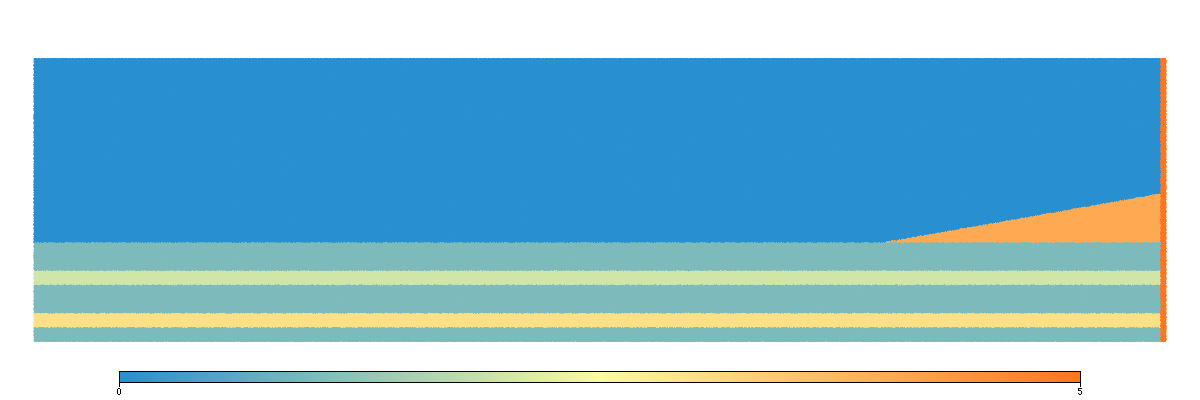

In [15]:
FigMaterials.show()

## Material properties

The swarm is initialialised but we now need to define the physical properties of our materials:

### Densities

In [16]:
air.density = nd(  10. * u.kilogram / u.metre**3)
sand1.density = nd(1560. * u.kilogram / u.metre**3)
sand2.density = nd(1560. * u.kilogram / u.metre**3)
sand3.density = nd(1560. * u.kilogram / u.metre**3)
microbeads.density = nd( 1480. * u.kilogram / u.metre**3)
wall.density = 0.

### Buoyancy Force

Define how the material densities interact with the gravity field.

In [17]:
densityMap = {}
for material in materials:
    densityMap[material.index] = material.density
    
densityFn = fn.branching.map(fn_key=materialIndexField, mapping=densityMap)

z_hat = ( 0.0, -1.0 )
buoyancyFn = densityFn * z_hat * gravity

## Material Rheologies

In [18]:
strainRateFn = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

In [19]:
air.rheology = Rheology()
sand1.rheology = Rheology()
sand2.rheology = Rheology()
sand3.rheology = Rheology()
microbeads.rheology = Rheology()
wall.rheology = Rheology()

In [20]:
# Assign function to materials
air.rheology.viscosity     = fn.misc.constant(nd(1.0e2  * u.pascal * u.second))
sand1.rheology.viscosity    = fn.misc.constant(nd(1.0e13 * u.pascal * u.second))
sand2.rheology.viscosity    = fn.misc.constant(nd(1.0e13 * u.pascal * u.second))
sand3.rheology.viscosity    = fn.misc.constant(nd(1.0e13 * u.pascal * u.second))
microbeads.rheology.viscosity = fn.misc.constant(nd(1.0e13 * u.pascal * u.second))
wall.rheology.viscosity = fn.misc.constant(nd(1.0e20 * u.pascal * u.second))

## Plasticity

In [21]:
Friction.data[:] = 0.0
FrictionSw.data[:] = 0.0

coord = fn.input()

materialMap = {microbeads.index: fn.misc.constant(np.radians(22.0)),
               wall.index: fn.misc.constant(np.radians(19.0)),
               sand1.index: fn.misc.constant(np.radians(36.0)),
               sand2.index: fn.misc.constant(np.radians(36.0)),
               sand3.index: fn.misc.constant(np.radians(36.0))}

FrictionMatFn = fn.branching.map(fn_key=materialIndexField, mapping=materialMap, fn_default=fn.misc.constant(0.))

conditions = [ (coord[1] < minY + nd(0.125 * u.centimetre) , fn.misc.constant(np.radians(19.0))),
               (coord[0] > maxX - nd(0.2 * u.centimetre) , fn.misc.constant(np.radians(19.0))),
               (coord[0] < minX + nd(0.2 * u.centimetre) , fn.misc.constant(np.radians(19.0))),
               (True, FrictionMatFn)]

FrictionFn = fn.branching.conditional(conditions)


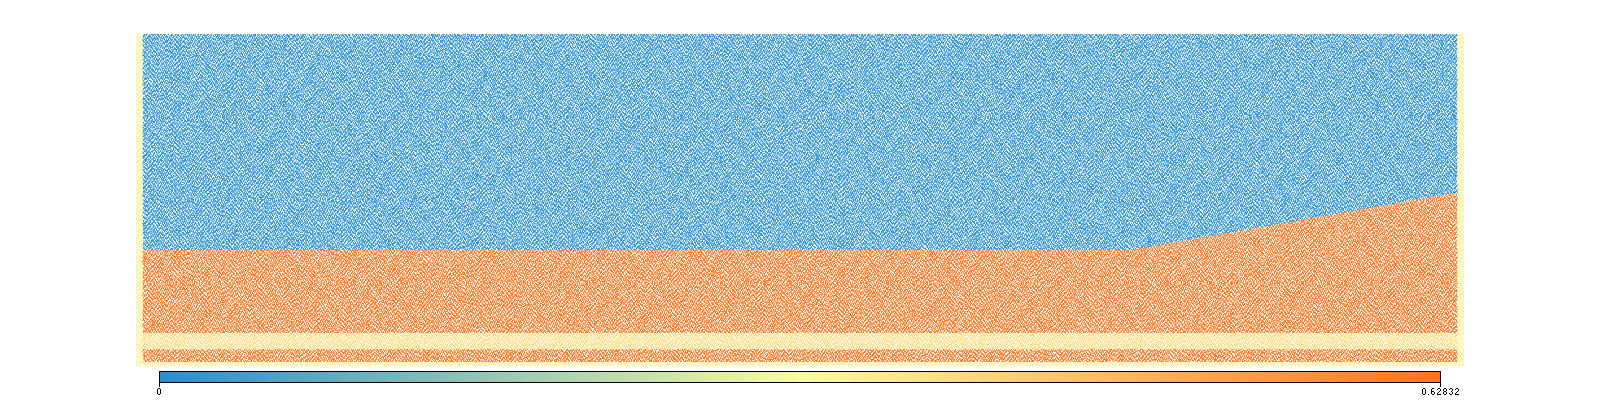

In [22]:
FigFriction = glucifer.Figure(name="Materials", store=GluciferStore, border=False, figsize=(1600,400))
FrictionVals = glucifer.objects.Points(swarm, FrictionFn, pointsize=1.0, colourBar=True)
FigFriction.append(FrictionVals)
FigFriction.show()

In [23]:
sand1.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))
sand1.rheology.friction = FrictionFn
sand2.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))
sand2.rheology.friction = FrictionFn
sand3.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))
sand3.rheology.friction = FrictionFn
microbeads.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))
microbeads.rheology.friction = fn.misc.constant(np.radians(22.0))
wall.rheology.friction = FrictionFn
wall.rheology.cohesion = fn.misc.constant(nd(10. * u.pascal))

for material in materials:
    rheology = material.rheology
    if rheology.cohesion != None and rheology.friction != None:
        C = rheology.cohesion
        Phi = rheology.friction
        YieldStress = C*fn.math.cos(Phi) + pressureField * fn.math.sin(Phi)
        rheology.plasticity =  0.5 * YieldStress / strainRate_2ndInvariantFn
    else:
        rheology.plasticity = rheology.viscosity

### Viscosity Limiter / Yielding

In [24]:
min_viscosity = air.rheology.viscosity
max_viscosity = nd(1e9 * u.pascal * u.second)

def viscosityLimiter(viscosityFn):
    maxBound = fn.misc.min(viscosityFn, max_viscosity)
    minMaxBound = fn.misc.max(maxBound, min_viscosity)
    return minMaxBound 
    
ViscosityMap = {}
for material in materials:
    ViscosityMap[material.index] = viscosityLimiter(material.rheology.viscosity)
    if material.rheology.plasticity:
        plasticity = material.rheology.plasticity
        viscosity = material.rheology.viscosity
        ViscosityMap[material.index] = viscosityLimiter(fn.misc.min(plasticity, viscosity))

viscosityFn = fn.branching.map(fn_key = materialIndexField, mapping = ViscosityMap)

BGViscosityMap = {}
for material in materials:
    BGViscosityMap[material.index] = viscosityLimiter(material.rheology.viscosity)

backgroundViscosityFn = fn.branching.map(fn_key = materialIndexField, mapping = BGViscosityMap)

SYconditions = [(viscosityFn < backgroundViscosityFn, strainRate_2ndInvariantFn),
                (True, 0.0)]

isYielding = fn.branching.conditional(SYconditions)

# Boundary conditions

In [25]:
right = mesh.specialSets["MaxI_VertexSet"]
left = mesh.specialSets["MinI_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

right -= base

velocityField.data[...] = 0.0

for node in right:
    coords = mesh.data[node]
    if coords[1] >= nd(-3.3 * u.centimeter):
        velocityField.data[node, 0] = -1.0 * nd(velocity)
    else:
        velocityField.data[node, 0] = -1.0 * (coords[1] - nd(-3.5 * u.centimeter)) / nd(0.2 * u.centimeter) * nd(velocity)

stokesBC = uw.conditions.DirichletCondition(variable = velocityField, indexSetsPerDof = (right+left, base))

# Set-up and solve initial isoviscous model

In [26]:
stokes = uw.systems.Stokes(velocityField = velocityField, 
                           pressureField = pressureField,
                           conditions    = stokesBC,
                           fn_viscosity  = backgroundViscosityFn, 
                           fn_bodyforce  = buoyancyFn)

solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
solver.set_penalty(1.0e6) 
solver.solve()

# Set-up Visco-plastic solve

In [27]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = stokesBC,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn)

solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
solver.set_penalty(1.0e6) 

# Pressure Calibration

In [28]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def smooth_pressure(mesh, pressure):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.
    NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
    Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressure, type=0)
    Nodes2Cell = uw.utils.MeshVariable_Projection(pressure, NodePressure, type=0)
    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh, pressureField)

# Main simulation loop

In [29]:
advector   = uw.systems.SwarmAdvector( swarm = swarm, velocityField=velocityField, order=2 )

population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=True,splitThreshold=0.15, 
                                                maxDeletions=2,maxSplits=10,
                                                particlesPerCell=18)

In [30]:
CFL = 0.5
time = 0.
endTime = nd(0.3 * u.hour)

checkpoint_number = 0
UpdateGluciferFigures(checkpoint_number, GluciferFigures)

while time < endTime:
    
    solver.solve(nonLinearIterate=True, callback_post_solve = pressure_calibrate)
    
    viscosityField.data[:] = viscosityFn.evaluate(swarm)
    strainRateVar.data[:] = strainRate_2ndInvariantFn.evaluate(swarm)
    
    checkpoint_number +=1
    UpdateGluciferFigures(checkpoint_number, GluciferFigures)

    dt = CFL * advector.get_max_dt()
         
    if uw.rank()==0:   
        print('checkpoint_number = {0:6d}; time = {1:.3e}'.format(checkpoint_number, sca.Dimensionalize(time, u.hours)))
        
    advector.integrate(dt, update_owners=True) 
    population_control.repopulate() 
       
    time +=dt

checkpoint_number =      1; time = 0.000e+00 hour
checkpoint_number =      2; time = 7.837e-03 hour
checkpoint_number =      3; time = 1.761e-02 hour
checkpoint_number =      4; time = 2.738e-02 hour
checkpoint_number =      5; time = 3.716e-02 hour
checkpoint_number =      6; time = 4.693e-02 hour
checkpoint_number =      7; time = 5.671e-02 hour
checkpoint_number =      8; time = 6.649e-02 hour
checkpoint_number =      9; time = 7.626e-02 hour
checkpoint_number =     10; time = 8.603e-02 hour
checkpoint_number =     11; time = 9.580e-02 hour
checkpoint_number =     12; time = 1.056e-01 hour
checkpoint_number =     13; time = 1.153e-01 hour
checkpoint_number =     14; time = 1.251e-01 hour
checkpoint_number =     15; time = 1.348e-01 hour
checkpoint_number =     16; time = 1.446e-01 hour
checkpoint_number =     17; time = 1.544e-01 hour
checkpoint_number =     18; time = 1.641e-01 hour
checkpoint_number =     19; time = 1.739e-01 hour
checkpoint_number =     20; time = 1.836e-01 hour



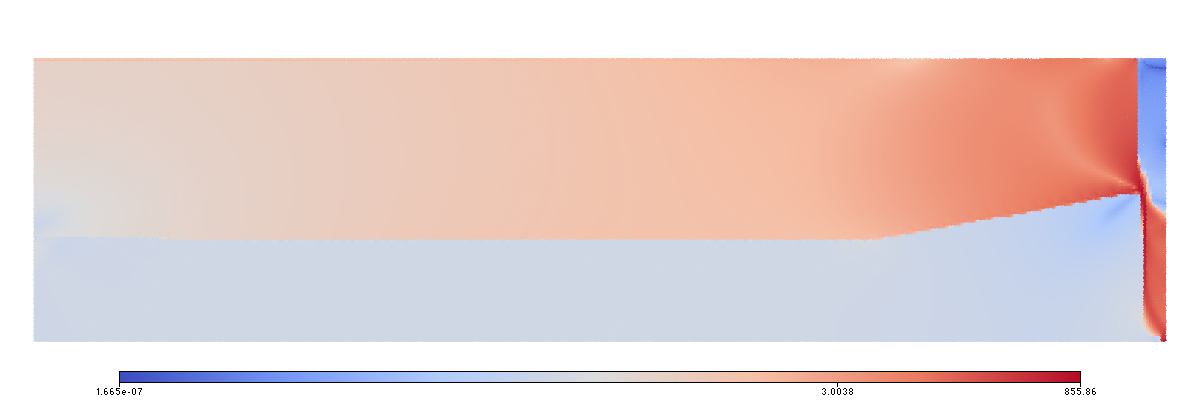

In [31]:
FigStrainRate.show()


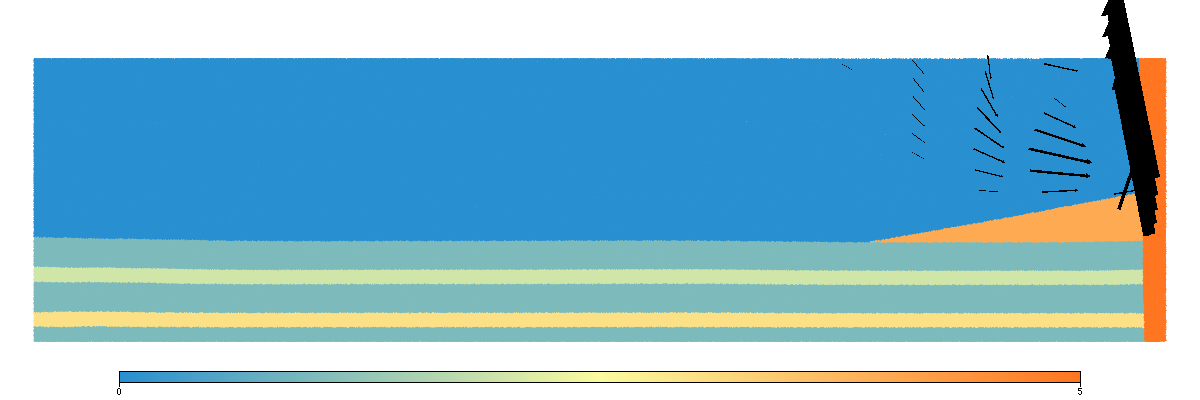

In [32]:
FigVelocities.show()


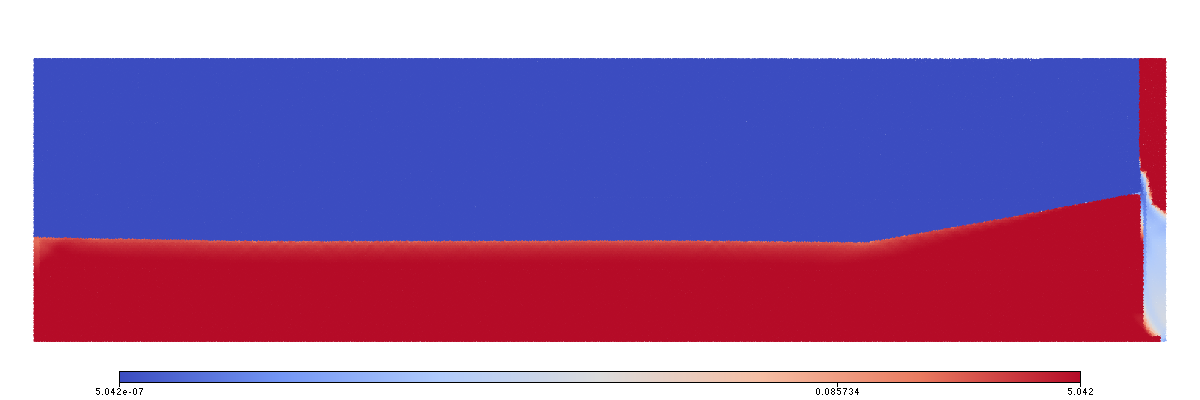

In [33]:
FigViscosity.show()


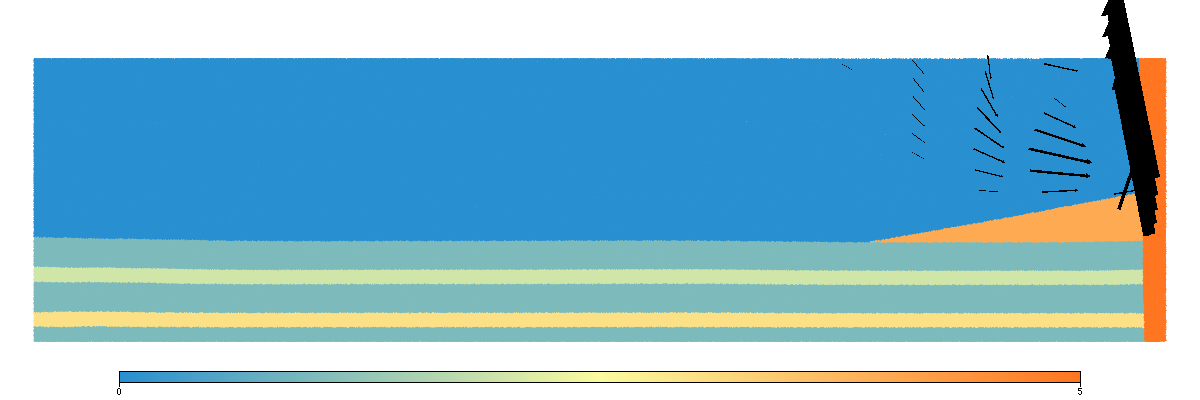

In [34]:
FigVelocities.show()